# Trial Summary 

Data preparation:
- Filter genes with less than 10 non-zero expressions spots
- Apply log transformation on the expressions

Model:
- Auto Encoders - encoding genes
- RMSE training loss excluding zeros

Results:
- Train final results = 0.87
- Train final results (after log transform) = 2.3869108535242765
- Valid final results = 0.72
- Valid final results (after log transform) = 2.0544332106438876
- Test final results = 0.73
- Test final results (after log transform) = 2.0750806076741224

# Imports

In [1]:
from os import path, listdir
from copy import deepcopy
import stlearn as st
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from scanpy_stlearn_loaders import StlearnLoader
import trainer_ae as trainer
import data_ae as get_data
from data_ae import get_expressions
from models import get_model
import tester_ae as tester
from loss import *
from results_analysis import *

In [2]:
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Load Data 

In [3]:
min_counts = 500
min_cells = 177
apply_log = True
batch_size = 128

In [4]:
dl_train, dl_valid, dl_test, _ = get_data.main(
    min_counts=min_counts,
    min_cells=min_cells,
    apply_log=apply_log, 
    batch_size=batch_size, 
    device=device
)

Finish loading the data


# Modelling

## Set HyperParameters

In [5]:
model_name = 'AE'
max_epochs = 300
early_stopping = 10
model_params = {
    'learning_rate': 0.1,
    'optimizer': "SGD",
    'latent_dim': 40,
    'batch_size': batch_size
}
trial_name = 'AE-LogTransform-NonZeroRMSE'

## Build Model 

In [6]:
model = get_model(model_name, model_params, dl_train)
optimizer = getattr(optim, model_params['optimizer'])(model.parameters(), lr=model_params['learning_rate'])
criterion = NON_ZERO_RMSELoss_AE()

## Train Model 

In [7]:
model, valid_loss = trainer.train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    max_epochs=max_epochs,
    early_stopping=early_stopping,
    dl_train=dl_train,
    dl_valid=dl_valid,
    dl_test=dl_test, 
    device=device,
    trial_name=trial_name
)

2022-10-01 13:38:11.298305: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-01 13:38:11.522811: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-01 13:38:11.522881: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-01 13:38:11.586756: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-01 13:38:12.965494: W tensorflow/stream_executor/platform/de

Training Results - Epoch[1] Avg loss: 0.73
Validation Results - Epoch[1] Avg loss: 0.98 | Avg RMSE: 0.98
Training Results - Epoch[2] Avg loss: 0.73
Validation Results - Epoch[2] Avg loss: 0.96 | Avg RMSE: 0.96
Training Results - Epoch[3] Avg loss: 0.73
Validation Results - Epoch[3] Avg loss: 0.94 | Avg RMSE: 0.94
Training Results - Epoch[4] Avg loss: 0.73
Validation Results - Epoch[4] Avg loss: 0.92 | Avg RMSE: 0.92
Training Results - Epoch[5] Avg loss: 0.73
Validation Results - Epoch[5] Avg loss: 0.90 | Avg RMSE: 0.90
Training Results - Epoch[6] Avg loss: 0.73
Validation Results - Epoch[6] Avg loss: 0.89 | Avg RMSE: 0.89
Training Results - Epoch[7] Avg loss: 0.74
Validation Results - Epoch[7] Avg loss: 0.87 | Avg RMSE: 0.87
Training Results - Epoch[8] Avg loss: 0.74
Validation Results - Epoch[8] Avg loss: 0.86 | Avg RMSE: 0.86
Training Results - Epoch[9] Avg loss: 0.75
Validation Results - Epoch[9] Avg loss: 0.85 | Avg RMSE: 0.85
Training Results - Epoch[10] Avg loss: 0.75
Validation 

Training Results - Epoch[78] Avg loss: 0.87
Validation Results - Epoch[78] Avg loss: 0.73 | Avg RMSE: 0.73
Training Results - Epoch[79] Avg loss: 0.87
Validation Results - Epoch[79] Avg loss: 0.73 | Avg RMSE: 0.73
Training Results - Epoch[80] Avg loss: 0.87
Validation Results - Epoch[80] Avg loss: 0.73 | Avg RMSE: 0.73
Training Results - Epoch[81] Avg loss: 0.87
Validation Results - Epoch[81] Avg loss: 0.73 | Avg RMSE: 0.73
Training Results - Epoch[82] Avg loss: 0.87
Validation Results - Epoch[82] Avg loss: 0.73 | Avg RMSE: 0.73
Training Results - Epoch[83] Avg loss: 0.87
Validation Results - Epoch[83] Avg loss: 0.73 | Avg RMSE: 0.73
Training Results - Epoch[84] Avg loss: 0.87
Validation Results - Epoch[84] Avg loss: 0.73 | Avg RMSE: 0.73
Training Results - Epoch[85] Avg loss: 0.87


2022-10-01 13:39:17,054 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[85] Avg loss: 0.72 | Avg RMSE: 0.72
Test Results - Avg RMSE: 0.73


In [10]:
train_res = 0.87
valid_res = 0.72
test_res = 0.73
print(f'- Train final results = {train_res}')
print(f'- Train final results (after log transform) = {np.exp(train_res)}')
print(f'- Valid final results = {valid_res}')
print(f'- Valid final results (after log transform) = {np.exp(valid_res)}')
print(f'- Test final results = {test_res}')
print(f'- Test final results (after log transform) = {np.exp(test_res)}')

- Train final results = 0.87
- Train final results (after log transform) = 2.3869108535242765
- Valid final results = 0.72
- Valid final results (after log transform) = 2.0544332106438876
- Test final results = 0.73
- Test final results (after log transform) = 2.0750806076741224


## Predict Test Expressions

In [11]:
_, df_test_preds = tester.test(
    model=model,
    dl_test=dl_test,
    device=device
)
df_test_preds_clustering = df_test_preds.copy()

# Results Analysis 

In [12]:
# Load Ordinal Encoders
with open(path.join('/', 'data', 'AE', 'genes_encoder.pkl'), 'rb') as f:
    ae_oe_genes = pickle.load(f)
with open(path.join('/', 'data', 'AE', 'spots_encoder.pkl'), 'rb') as f:
    ae_oe_spots = pickle.load(f)
    
dl_test_ae = torch.load(path.join('/', 'data', 'AE', 'dl_test.pth'))
ae_test_matrix, _ = dl_test_ae.dataset.get_all_data()
df_test_true_ra = pd.DataFrame(ae_test_matrix.to('cpu'))
df_test_true_ra = df_test_true_ra.melt(ignore_index=False).reset_index().rename(columns={'index': 'gene', 'variable': 'spot', 'value': 'y'})
print(df_test_true_ra.shape)
df_test_true_ra.head()


df_test_preds_ra = df_test_preds.melt(ignore_index=False).reset_index().rename(columns={'index': 'gene', 'variable': 'spot', 'value': 'y_pred'})
print(df_test_preds_ra.shape)
df_test_preds_ra.head()

df_test_preds = pd.merge(left=df_test_true_ra, right=df_test_preds_ra, how='inner', on=['gene', 'spot'])
print(df_test_preds.shape)
df_test_preds['y_fixed'] = np.exp(df_test_preds['y'])
df_test_preds['y_pred_fixed'] = np.exp(df_test_preds['y_pred'])

y_col = 'y'
y_pred_col = 'y_pred'

df_test_preds['error'] = df_test_preds[y_col] - df_test_preds[y_pred_col]
df_test_preds.head()

(7440615, 3)
(7440615, 3)
(7440615, 4)


,gene,spot,y,y_pred,y_fixed,y_pred_fixed,error
0,0,0,0.000000,0.725131,1.0,2.065002,-0.725131
1,1,0,0.000000,0.731216,1.0,2.077605,-0.731216
2,2,0,0.000000,0.728367,1.0,2.071694,-0.728367
3,3,0,0.000000,0.730169,1.0,2.075432,-0.730169
4,4,0,0.693147,0.730793,2.0,2.076726,-0.037645


## Errors Distribution 

count    7.440615e+06
mean    -3.519484e-01
std      7.672233e-01
min     -9.961715e-01
25%     -9.605850e-01
50%     -7.819299e-01
75%      1.098390e-01
max      6.570051e+00
Name: error, dtype: float64


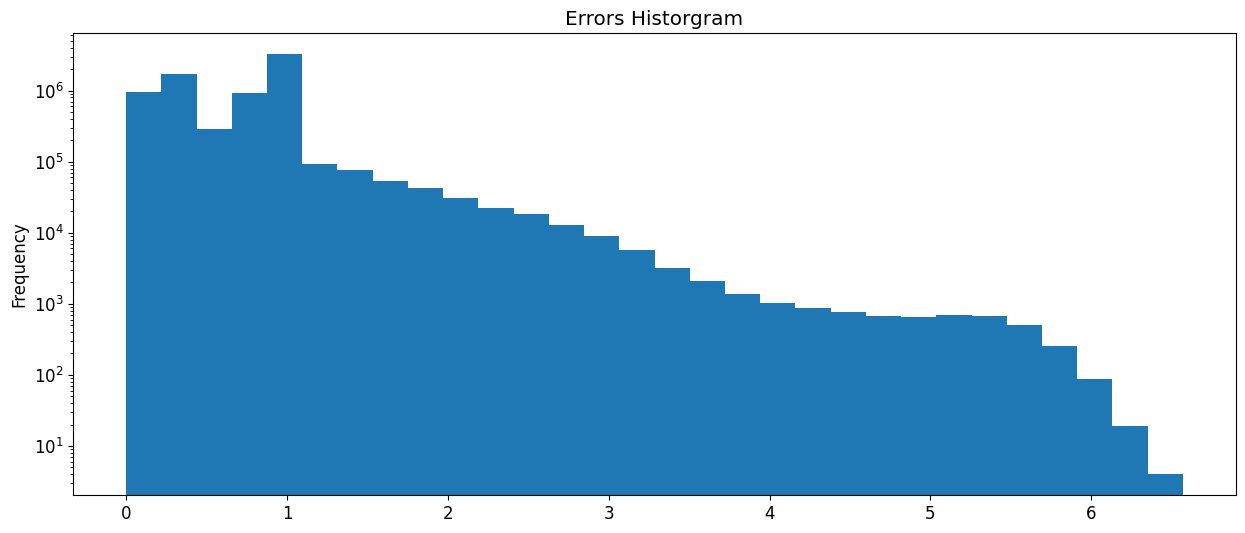

In [13]:
error_distribution(df_test_preds)

## Spots Errors Distribution 

In [14]:
spots_error_distribution(df_test_preds)

count    1185.000000
mean       -0.351949
std         0.235740
min        -0.718348
25%        -0.554328
50%        -0.385483
75%        -0.142652
max         0.245146
Name: error, dtype: float64


## Genes Errors Distribution 

In [15]:
genes_error_distribution(df_test_preds)

count    6279.000000
mean       -0.351949
std         0.461679
min        -0.783570
25%        -0.640036
50%        -0.508421
75%        -0.255819
max         4.187053
Name: error, dtype: float64


## Errors Heat Map 

(1185, 6279)


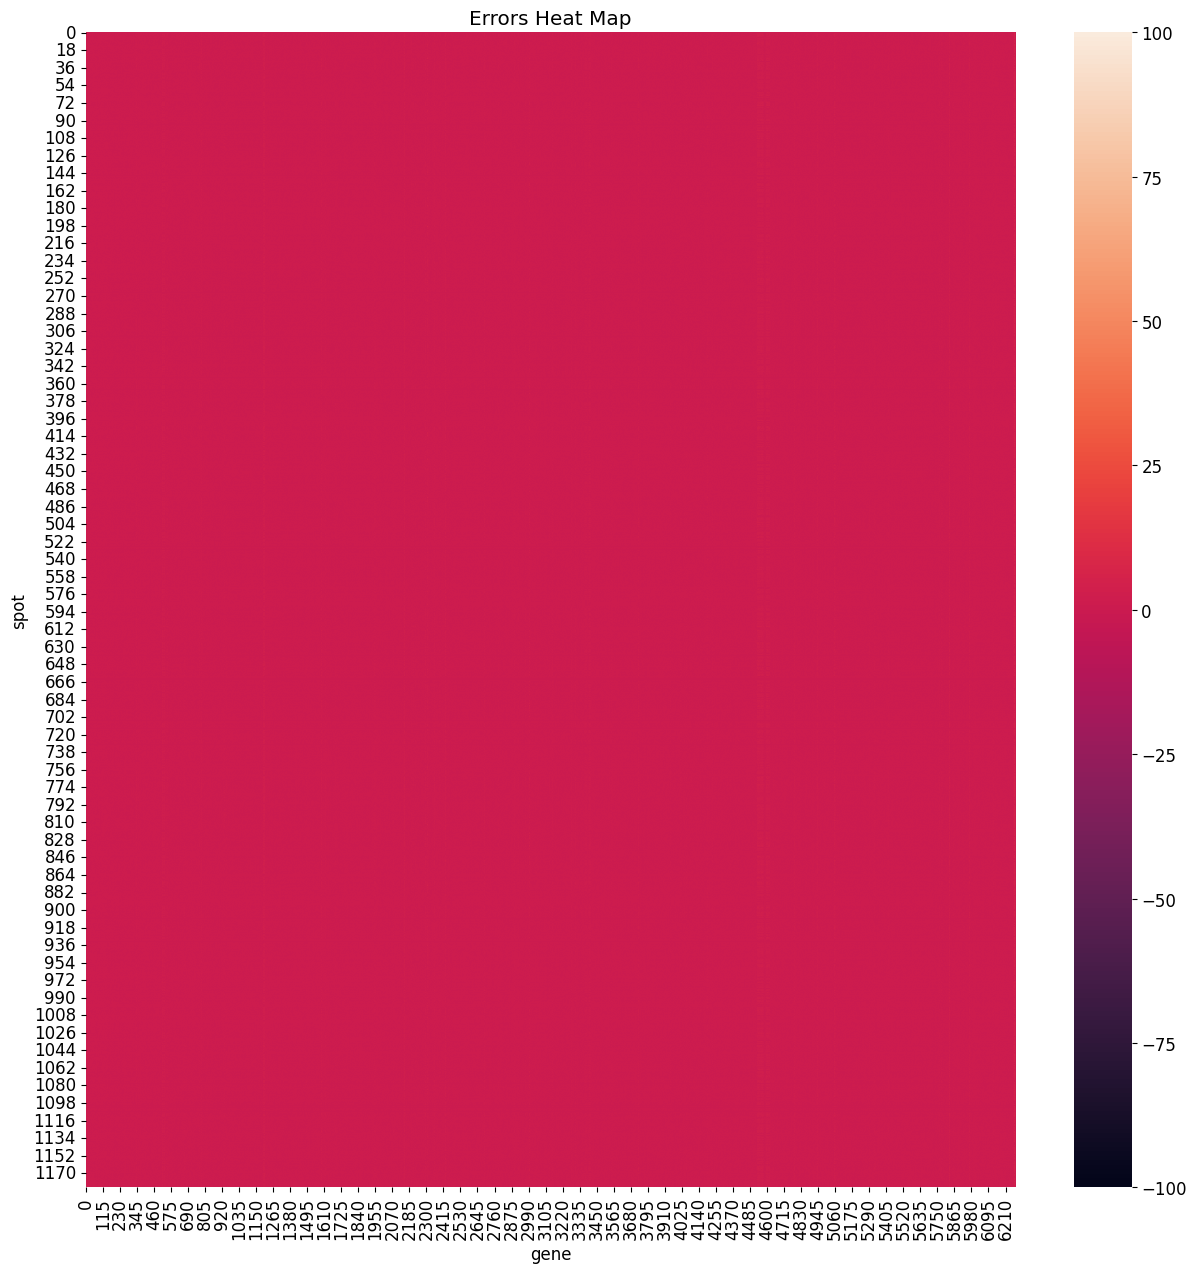

In [16]:
error_heat_map(df_test_preds, vmin=-100, vmax=100)

# PCA + KMeans Clustering 

In [17]:
_, obj, _, _ = get_expressions(min_counts=min_counts, min_cells=min_cells, apply_log=apply_log)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# spots: 1185 | # genes: 32285
New shape after filtering: (1185, 6279)
Log transformation step is finished in adata.X
Data shape: (7440615, 3)
Number of genes: 6279
Number of spots: 1185


In [18]:
df_test_preds_matrix = pd.DataFrame(df_test_preds_clustering.T)
df_test_preds_matrix.columns = ae_oe_genes.inverse_transform(df_test_preds_matrix.columns.values.reshape(-1, 1)).reshape(1, -1)[0]
df_test_preds_matrix.index = ae_oe_spots.inverse_transform(df_test_preds_matrix.index.values.reshape(-1, 1)).reshape(1, -1)[0]
display(df_test_preds_matrix.head())
tmp_genes_locations = [obj.var.index.get_loc(key=gene_key) for gene_key in df_test_preds_matrix.columns]
# Replace the values
obj.X[:, tmp_genes_locations] = df_test_preds_matrix.values

,0610009B22Rik,0610009L18Rik,0610010K14Rik,0610012G03Rik,1110004F10Rik,1110008P14Rik,1110032A03Rik,1110038B12Rik,1110038F14Rik,1110051M20Rik,...,mt-Co1,mt-Co2,mt-Co3,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd3,mt-Nd4,mt-Nd4l,mt-Nd5
AAACAAGTATCTCCCA-1,0.725131,0.731216,0.728367,0.730169,0.730793,0.724714,0.729173,0.718429,0.725865,0.730239,...,0.718302,0.725707,0.731416,0.725523,0.717586,0.724306,0.718992,0.731248,0.730638,0.724919
AAACCGGGTAGGTACC-1,0.989469,0.990763,0.990222,0.990567,0.990701,0.989406,0.990390,0.987763,0.989645,0.990603,...,0.987738,0.989616,0.990796,0.989587,0.987471,0.989313,0.987908,0.990768,0.990654,0.989434
AAACCGTTCGTCCAGG-1,0.991232,0.992384,0.991899,0.992206,0.992322,0.991176,0.992043,0.989725,0.991388,0.992237,...,0.989691,0.991359,0.992407,0.991340,0.989471,0.991092,0.989847,0.992383,0.992280,0.991202
AAACGAGACGGTTGAT-1,0.991308,0.992460,0.991974,0.992281,0.992400,0.991248,0.992119,0.989794,0.991460,0.992310,...,0.989777,0.991439,0.992488,0.991411,0.989549,0.991168,0.989922,0.992462,0.992356,0.991279
AAACTGCTGGCTCCAA-1,0.988323,0.989737,0.989131,0.989513,0.989658,0.988254,0.989314,0.986511,0.988518,0.989554,...,0.986484,0.988476,0.989777,0.988455,0.986210,0.988153,0.986672,0.989744,0.989611,0.988286


/usr/local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Normalization step is finished in adata.X
Log transformation step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


<Figure size 640x480 with 0 Axes>

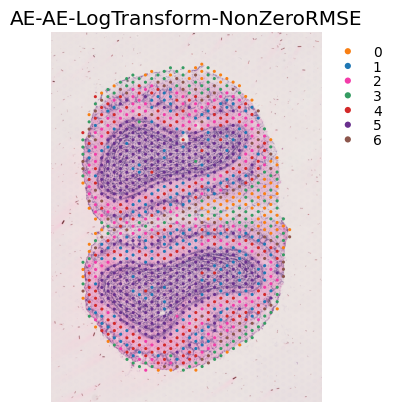

In [19]:
pca_kmeans_clustering(
    data_obj=obj, 
    title=f'AE-{trial_name}'
)